This is experiment 01 with transfer learning using EfficientnetB0 with all the layers frozen. Additionally,  a Globalaveragepooling layer and a Dense layer is added for feture extraction purpose.

1. Import the data

In [78]:
import zipfile
import urllib.request
import os
import shutil

def download_and_unzip(url, file_name):
    urllib.request.urlretrieve(url, file_name)
    print('Beginning file download...')

    #File Extraction
    zip_ref =  zipfile.ZipFile(file_name, 'r')
    zip_ref.extractall()
    zip_ref.close()
    if os.path.exists('__MACOSX'):
        shutil.rmtree('__MACOSX')
    if os.path.isfile(file_name):
        os.remove(file_name)
    return


url =  'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'
file_name = '10_food_classes_10_percent.zip'

download_and_unzip(url, file_name)

Beginning file download...


2. Explore the imported folders

In [83]:
import os 
def dir_explore(dir_path):
    for root, dirs, files in os.walk(dir_path):
        # root : Prints out directories only from what you specified.
        # dirs : Prints out sub-directories from root.
        # files : Prints out all files from root and directories.
        print(f"There are {len(dirs)} directories and {len(files)} files in {root} folder.")
    return

dir_explore('10_food_classes_10_percent')

There are 2 directories and 0 files in 10_food_classes_10_percent folder.
There are 10 directories and 0 files in 10_food_classes_10_percent\test folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\chicken_curry folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\chicken_wings folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\fried_rice folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\grilled_salmon folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\hamburger folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\ice_cream folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\pizza folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\ramen folder.
There are 0 directories and 250 files in 10_food_classes_10_percent\test\steak folder.
There are 0 directories a

3. Initializing the pipe mode to extract images for training and testing.

In [85]:
import tensorflow as tf

train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, image_size=IMG_SIZE, label_mode='categorical', batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMG_SIZE, label_mode='categorical', batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


4. Importing the EfficientNetB0 pretrained model. 
    Setting trainable parameters as false to freeze layers. 
    using tensorflow functional API to construct model.

In [86]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape= (224,224,3))
x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)


16719872/16705208 [==============================] - 1s 0us/step
Shape after base_model: (None, 7, 7, 1280)


5. Defining the callbacks for tensorboard, early stopping and saving the model at every epoch.

In [88]:
import datetime
import tensorflow as tf
def create_callbacks(tensorboard_dir_name, checkpoint_path, experiment_name, monitor='val_accuracy', patience= 5, verbose= 0):
    log_dir = tensorboard_dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, 
                                                                patience=patience, 
                                                                verbose=verbose)
    check_point_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                save_weights_only=False,
                                                                verbose=verbose)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return [tensorboard_callback, early_stopping_callback, check_point_callback]

6. Compiling and training the model.

In [90]:
model_0.compile(loss= 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_0_history = model_0.fit(train_data, 
                            epochs=5, 
                            steps_per_epoch=len(train_data), 
                            validation_data=test_data, 
                            validation_steps=int(0.25*len(test_data)), 
                            callbacks=create_callbacks(tensorboard_dir_name='TensorBoard',
                                                        checkpoint_path = 'Models/Exp_01_Models/model_0_ep_{epoch:02d}_val_accuracy_{val_accuracy:.02f}.h5', 
                                                        experiment_name='EfficientNet_FineTuning_Exp_01'))

Saving TensorBoard log files to: TensorBoard/EfficientNet_FineTuning_Exp_01/20211124-210315
Epoch 1/5


C:\Users\Sahil\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 41s 2s/step - loss: 1.8636 - accuracy: 0.4307 - val_loss: 1.2904 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 33s 1s/step - loss: 1.1310 - accuracy: 0.7400 - val_loss: 0.9012 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - 32s 1s/step - loss: 0.8379 - accuracy: 0.8053 - val_loss: 0.7469 - val_accuracy: 0.7961
Epoch 4/5
24/24 [==============================] - 32s 1s/step - loss: 0.6898 - accuracy: 0.8320 - val_loss: 0.6342 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 33s 1s/step - loss: 0.6002 - accuracy: 0.8507 - val_loss: 0.6109 - val_accuracy: 0.8240


7. Model evaluation

In [147]:
model_0.evaluate(test_data)

79/79 [==============================] - 59s 739ms/step - loss: 0.6074 - accuracy: 0.8412


[0.6073856949806213, 0.8411999940872192]

84% of validation accuracy is a really good number considering the amount of training data and epoch number.

8. Extracting labels and predictions. (Incase if we need in future)

In [109]:
import numpy as np
predictions = model_0.predict(test_data)
pred = [np.argmax(i) for i in predictions]
labels = np.array([])
for x, y in test_data:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis = -1)])

9. Plotting the loss curves.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


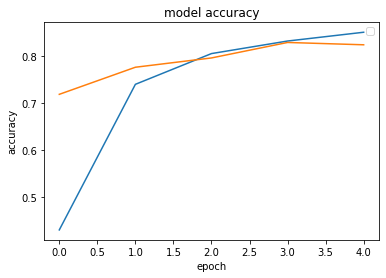

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


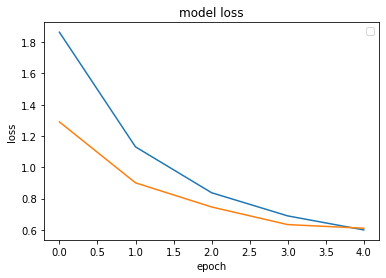

In [149]:
import matplotlib.pyplot as plt
def plot_loss_curves(model_history):

    print(model_history.history.keys())
    # summarize history for accuracy
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()


plot_loss_curves(model_0_history)

10. Exploring model architecture. (Just out of curiosity)

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_9
1 rescaling_5
2 normalization_5
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_5 (Rescaling)        (None, None, None,   0           ['input_9[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_5 (Normalization  (None, None, None,   7          ['rescaling_5[0][0]']            
 )                              3)                                                   

In [ ]:
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________
